In [67]:
import torch
torch.set_default_dtype(torch.float64)
from torch.utils.data import TensorDataset, DataLoader

import math
import gpytorch
from gpytorch.metrics import negative_log_predictive_density, mean_squared_error, mean_standardized_log_loss,mean_absolute_error

import matplotlib
from matplotlib import pyplot as plt

from tqdm.notebook import tqdm
import numpy as np
from uci_datasets import Dataset
from sklearn.model_selection import train_test_split
from scipy.io import loadmat

In [52]:

'''
autompg (392, 7)
concreteslump (103, 7)
energy (768, 8)
forest (517, 12)
solar (1066, 10)
stock (536, 11)
yacht (308, 6)
airfoil (1503, 5)
autos (159, 25)
breastcancer (194, 33)
concrete (1030, 8)
housing (506, 13)
machine (209, 7)
pendulum (630, 9)
servo (167, 4)
wine (1599, 11)
'''


# Parameters
datasets = [
    'autompg', 
    'concreteslump', 
    'energy', 
    'forest', 
    'solar', 
    'stock', 
    'yacht',
    'airfoil', 
    'autos', 
    'breastcancer', 
    'concrete', 
    'housing', 
    'machine',
    'pendulum', 
    'servo', 
    'wine',
]

In [2]:
dataset_name = "housing"
full_dataset = Dataset(dataset_name)
N,DIM = full_dataset.x.shape

X,y = full_dataset.x, full_dataset.y

if dataset_name=="autos":  
    X = np.delete(X,[8],axis=1)

if dataset_name == "sml":
    X = np.delete(X,[2, 20, 21, 22],axis=1)


X = X / np.std(X, axis=0)[None, :]    # standardize
# X = X - X.min(0)[0]                   # normalize
# X = 2 * (X / X.max(0)[0]) - 1
y = y / np.std(y, axis=0)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

y_train = y_train.squeeze()
y_test = y_test.squeeze()

len(X_train), len(X_test)

housing dataset, N=506, d=13


(404, 102)

In [3]:
X_train,y_train= torch.from_numpy(X_train),torch.from_numpy(y_train)
X_test,y_test = torch.from_numpy(X_test),torch.from_numpy(y_test)

In [35]:
# GP model with kernel as input
class GP(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, kernel=None, mean=None):
        likelihood = gpytorch.likelihoods.GaussianLikelihood()
        super(GP, self).__init__(train_x, train_y, likelihood)
        self.mean_module = mean or gpytorch.means.ConstantMean()
        self.covar_module = kernel or gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel(ard_num_dims=train_x.shape[1])
        )
        if isinstance(kernel, gpytorch.kernels.SpectralDeltaKernel) or isinstance(kernel, gpytorch.kernels.SpectralMixtureKernel):
            self.covar_module.initialize_from_data(train_x, train_y)

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [16]:
model = GP(X_train, y_train)

optimizer = torch.optim.Adam(model.parameters(),lr = 0.01)
mll = gpytorch.mlls.ExactMarginalLogLikelihood(model.likelihood,model)


loss_vals = []
for i in tqdm(range(1000)):
    optimizer.zero_grad()
    output = model(X_train)
    loss = - mll(output,y_train)
    loss.backward()
    optimizer.step()

    loss_vals.append(loss.item())

  0%|          | 0/1000 [00:00<?, ?it/s]

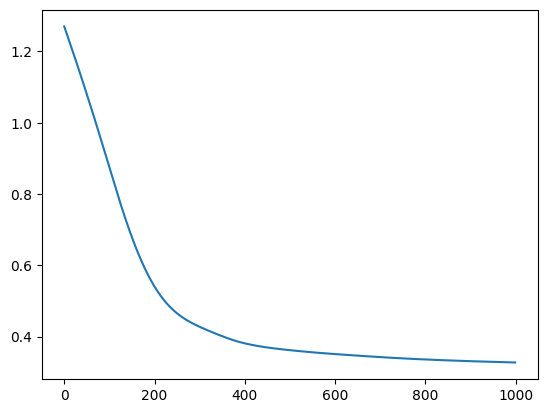

In [17]:
plt.plot(loss_vals)

In [18]:
model.eval()
preds = model.likelihood(model(X_test))
print("MAE: ", mean_absolute_error(preds,y_test).detach().numpy())
print("RMSE: ", torch.sqrt(mean_squared_error(preds,y_test)).detach().numpy())
print("MSLL: ", mean_standardized_log_loss(preds,y_test).detach().numpy())
print("NLPD: ", negative_log_predictive_density(preds,y_test).detach().numpy())

MAE:  0.23363459316769516
RMSE:  0.2996136018951724
MSLL:  0.22039373348719554
NLPD:  0.19846362848379218


In [50]:
scale_params = [p for name,p in model.named_parameters() if 'lengthscale' in name]
scale_params

[Parameter containing:
 tensor([[2.7862, 5.5833, 5.5698, 7.8648, 0.5768, 2.5091, 3.1187, 1.4087, 2.4451,
          0.0332, 5.3436, 5.3319, 0.5863]], requires_grad=True)]

## Kernels

In [36]:
def get_kernels(dim):

    kernels = [
        gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel(ard_num_dims=dim)),
        gpytorch.kernels.ScaleKernel(gpytorch.kernels.MaternKernel(nu=1.5,ard_num_dims=dim)),
        gpytorch.kernels.ScaleKernel(gpytorch.kernels.MaternKernel(nu=2.5,ard_num_dims=dim)),
        gpytorch.kernels.ScaleKernel(gpytorch.kernels.RQKernel(ard_num_dims=dim)),
        gpytorch.kernels.LinearKernel(),
        # gpytorch.kernels.ScaleKernel(gpytorch.kernels.CosineKernel()),
        gpytorch.kernels.ScaleKernel(gpytorch.kernels.PolynomialKernel(power=2)),
        
        # Spectral kernels: random freqs, learned freqs and learned spectral mixture
        gpytorch.kernels.ScaleKernel(gpytorch.kernels.RFFKernel(num_dims=dim,num_samples=150)),
        gpytorch.kernels.ScaleKernel(gpytorch.kernels.SpectralDeltaKernel(num_dims=dim,num_deltas=150)),
        gpytorch.kernels.SpectralMixtureKernel(num_mixtures=4),   # this kernel should not be combined with ScaleKernel 
        ]
    
    return kernels

In [37]:
kernel_names = ['RBF',
                'Matern3/2',
                'Matern5/2',
                'RQ',
                'Linear',
                # 'Cos',
                'Poly',
                'RFF-RBF',
                'SpecDelta',
                'SpecMix',
                ]

In [38]:
gamma=0.8
0.1*gamma**np.arange(10)

array([0.1       , 0.08      , 0.064     , 0.0512    , 0.04096   ,
       0.032768  , 0.0262144 , 0.02097152, 0.01677722, 0.01342177])

In [39]:
def run_gp(X_train,y_train,X_test,y_test,kernel):
    model = GP(X_train, y_train,kernel=kernel)

    optimizer = torch.optim.Adam(model.parameters(),lr = 0.1)
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(model.likelihood,model)
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.8)


    loss_vals = []
    for _ in range(10):             # epochs
        for _ in range(100):        # iterations per epoch
            optimizer.zero_grad()
            output = model(X_train)
            loss = - mll(output,y_train)
            loss.backward()
            optimizer.step()
            loss_vals.append(loss.item())
            
        scheduler.step()    

    model.eval()
    preds = model.likelihood(model(X_test))    

    mae = mean_absolute_error(preds,y_test).detach().numpy().item()
    rmse = torch.sqrt(mean_squared_error(preds,y_test)).detach().numpy().item()
    mlloss = mean_standardized_log_loss(preds,y_test).detach().numpy().item()
    try:
        nlpd = negative_log_predictive_density(preds,y_test).detach().numpy().item()
    except:
        nlpd = []
    

    results = {"mae": [mae],
                'rmse': [rmse],
                'mll': [mlloss],
                'nlpd': [nlpd],
                }

    return results, loss_vals
    

In [40]:
from tqdm.notebook import tqdm  
datasets_faltan = ['solar','airfoil','concrete','wine']
datasets = datasets_faltan

num_datasets = len(datasets)
num_kernels = 6
num_seeds = 3

test_datasets = datasets[:num_datasets]
all_results = dict()
for name in test_datasets:
    all_results.update({name: dict()})


for dataset_name in test_datasets:
    full_dataset = Dataset(dataset_name)

    progress_bar = tqdm(total=num_kernels * num_seeds, desc=f"Progress for {dataset_name}", unit="iteration")

    X,y = full_dataset.x, full_dataset.y

    if dataset_name=="autos":  
        X = np.delete(X,[8],axis=1)
    
    if dataset_name=="solar":  
        X = np.delete(X,[-1],axis=1)     

    if dataset_name == "sml":
        X = np.delete(X,[2, 20, 21, 22],axis=1)

    # standardize
    X = X / np.std(X, axis=0)[None, :]    
    y = y / np.std(y, axis=0)
    for split in range(num_seeds):
        X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.1,random_state=split+50,shuffle=True)

        y_train = y_train.squeeze()
        y_test = y_test.squeeze()

        X_train,y_train,X_test,y_test= torch.from_numpy(X_train),torch.from_numpy(y_train),torch.from_numpy(X_test),torch.from_numpy(y_test)

        kernels = get_kernels(X_train.shape[1])
        kernel_bar = tqdm(total=num_kernels, desc=f"Running kernels for {dataset_name}, split {split}", leave=False)

        for k,kernel in enumerate(kernels[:num_kernels]):
            if kernel_names[k] not in all_results[dataset_name]:
                all_results[dataset_name][kernel_names[k]] = {
                    "rmse": [],
                    "nlpd": [],
                    "mae": [],
                    "mll": []
                }
            try:
                results,_ = run_gp(X_train,y_train,X_test,y_test,kernel)
                # save the results
                all_results[dataset_name][kernel_names[k]]["rmse"].extend(results["rmse"])
                all_results[dataset_name][kernel_names[k]]["nlpd"].extend(results["nlpd"])
                all_results[dataset_name][kernel_names[k]]["mae"].extend(results["mae"])
                all_results[dataset_name][kernel_names[k]]["mll"].extend(results["mll"])
            except Exception as e:
                print(f"Error in dataset {dataset_name}, split {split}, kernel {kernel}: {str(e)}")
            
            progress_bar.update(1) 
            kernel_bar.update(1)
            
        # kernel_bar.close()
        


solar dataset, N=1066, d=10


Progress for solar:   0%|          | 0/18 [00:00<?, ?iteration/s]

Running kernels for solar, split 0:   0%|          | 0/6 [00:00<?, ?it/s]

Running kernels for solar, split 1:   0%|          | 0/6 [00:00<?, ?it/s]

Running kernels for solar, split 2:   0%|          | 0/6 [00:00<?, ?it/s]

airfoil dataset, N=1503, d=5


Progress for airfoil:   0%|          | 0/18 [00:00<?, ?iteration/s]

Running kernels for airfoil, split 0:   0%|          | 0/6 [00:00<?, ?it/s]

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-07 to the diagonal
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(


Running kernels for airfoil, split 1:   0%|          | 0/6 [00:00<?, ?it/s]

Running kernels for airfoil, split 2:   0%|          | 0/6 [00:00<?, ?it/s]

concrete dataset, N=1030, d=8


Progress for concrete:   0%|          | 0/18 [00:00<?, ?iteration/s]

Running kernels for concrete, split 0:   0%|          | 0/6 [00:00<?, ?it/s]

Running kernels for concrete, split 1:   0%|          | 0/6 [00:00<?, ?it/s]

Running kernels for concrete, split 2:   0%|          | 0/6 [00:00<?, ?it/s]

wine dataset, N=1599, d=11


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/gpytorch/distributions/multivariate_normal.py:319: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-10.
  warnings.warn(


Progress for wine:   0%|          | 0/18 [00:00<?, ?iteration/s]

Running kernels for wine, split 0:   0%|          | 0/6 [00:00<?, ?it/s]

Running kernels for wine, split 1:   0%|          | 0/6 [00:00<?, ?it/s]

Running kernels for wine, split 2:   0%|          | 0/6 [00:00<?, ?it/s]

In [41]:
all_results

{'solar': {'RBF': {'rmse': [0.601323655746481,
    1.067002207398389,
    0.6623930411347618],
   'nlpd': [1.0270984767269828, 1.5279688861661311, 1.0618707326450398],
   'mae': [0.3770158512231601, 0.5860023947696096, 0.4441310921817095],
   'mll': [1.0268496783334908, 1.5394274092304159, 1.0697878048933387]},
  'Matern3/2': {'rmse': [0.636293801949193,
    1.0822816055552815,
    0.6762037560232447],
   'nlpd': [1.0378396826207705, 1.5533509707875108, 1.0704910244099146],
   'mae': [0.39233389512339983, 0.5984635331896916, 0.4548421913542993],
   'mll': [1.0410825296758979, 1.5645780381594245, 1.0807441674468583]},
  'Matern5/2': {'rmse': [0.6047331505007952,
    1.082467433501799,
    0.6722203971077744],
   'nlpd': [1.030961416197045, 1.5457914592602477, 1.0690151531659382],
   'mae': [0.3804663176448031, 0.6004981031572957, 0.4502269882156585],
   'mll': [1.0306584896479294, 1.5579974109656924, 1.0781223432429443]},
  'RQ': {'rmse': [0.6530599084914608, 1.0852740723673284, 0.71571

In [43]:
len(all_results_copy), len(all_results)

(16, 4)

In [44]:
datasets_faltan = ['solar','airfoil','concrete','wine']
for name in datasets_faltan:
    all_results_copy[name] = all_results[name]

## save results

In [46]:
%%script true
import pickle
with open('all_results_full.pickle', 'wb') as handle:
    pickle.dump(all_results_copy, handle, protocol=pickle.HIGHEST_PROTOCOL)

## plot results

In [47]:
import os
import pickle
import numpy as np

def load_results(filename):
    with open(filename, 'rb') as f:
        return pickle.load(f)
all_results_full = load_results('all_results_full.pickle')

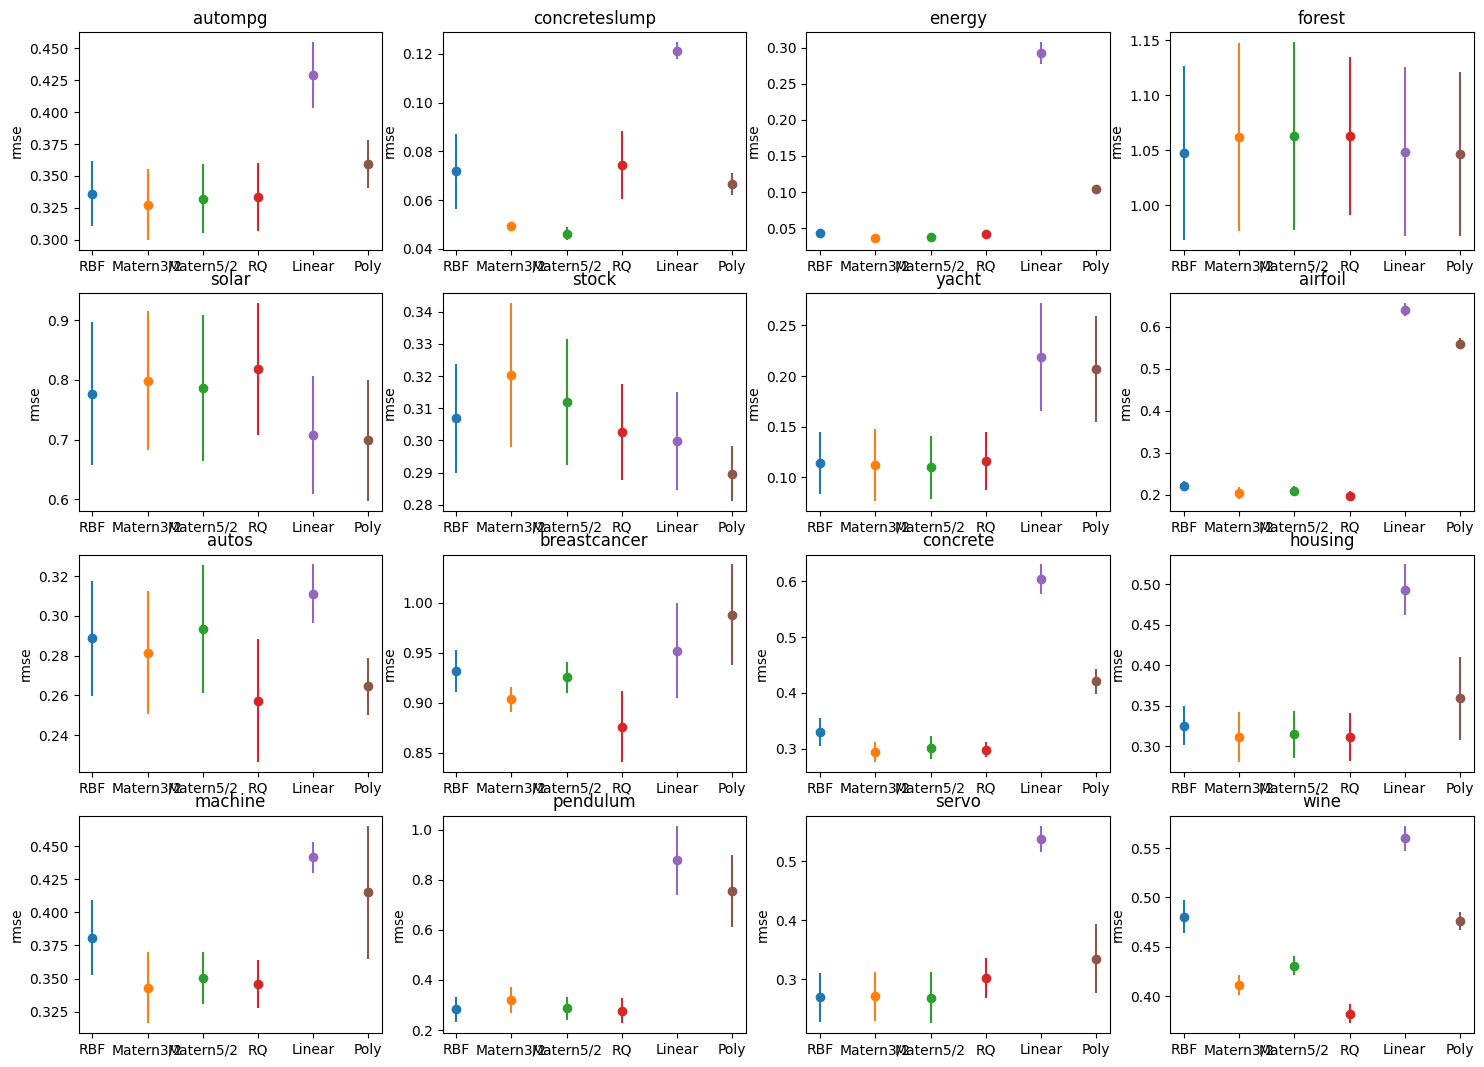

In [65]:
datasets = [
    'autompg', 
    'concreteslump', 
    'energy', 
    'forest', 
    'solar', 
    'stock', 
    'yacht',
    'airfoil', 
    'autos', 
    'breastcancer', 
    'concrete', 
    'housing', 
    'machine',
    'pendulum', 
    'servo', 
    'wine',
]

error_measure = "rmse"
plt.figure(figsize=(18,13))
for j,dataset_name in enumerate(datasets):
    plt.subplot(4,4,j+1)
    for i, kernel_name in enumerate(kernel_names[:num_kernels]):
        aqui = np.array(all_results_full[dataset_name][kernel_name][error_measure])
        plt.scatter(i,np.nanmean(aqui))
        # print(np.sum(1-np.isnan(aqui)))
        plt.errorbar(i,np.nanmean(aqui),np.nanstd(aqui)/np.sqrt(np.sum(1-np.isnan(aqui))))
    plt.xticks(range(num_kernels),kernel_names[:num_kernels])  
    # plt.ylim((0,1)) 
    plt.ylabel(error_measure) 
    plt.title(dataset_name)

 

error_measure = "mll"
plt.figure(figsize=(18,13))
for j,dataset_name in enumerate(datasets):
    plt.subplot(4,4,j+1)
    for i, kernel_name in enumerate(kernel_names[:num_kernels]):
        aqui = np.array(all_results_full[dataset_name][kernel_name][error_measure])
        plt.scatter(i,np.nanmean(aqui))
        # print(np.sum(1-np.isnan(aqui)))
        plt.errorbar(i,np.nanmean(aqui),np.nanstd(aqui)/np.sqrt(np.sum(1-np.isnan(aqui))))
    plt.xticks(range(num_kernels),kernel_names[:num_kernels])  
    # plt.ylim((0,1)) 
    plt.ylabel(error_measure) 
    plt.title(dataset_name) 

Testing Matern

In [32]:
%%script true
dataset_name = 'solar'  #"concrete"
full_dataset = Dataset(dataset_name)
N,DIM = full_dataset.x.shape

X,y = full_dataset.x, full_dataset.y

if dataset_name=="autos":  
    X = np.delete(X,[8],axis=1)
if dataset_name=="solar":  
    X = np.delete(X,[-1],axis=1)    

if dataset_name == "sml":
    X = np.delete(X,[2, 20, 21, 22],axis=1)


X = X / np.std(X, axis=0)[None, :]    # standardize
# X = X - X.min(0)[0]                   # normalize
# X = 2 * (X / X.max(0)[0]) - 1
y = y / np.std(y, axis=0)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

y_train = y_train.squeeze()
y_test = y_test.squeeze()

len(X_train), len(X_test)

In [9]:
%%script true
X_train,y_train= torch.from_numpy(X_train),torch.from_numpy(y_train)
X_test,y_test = torch.from_numpy(X_test),torch.from_numpy(y_test)
model = GP(X_train, y_train,kernel=gpytorch.kernels.ScaleKernel(
    gpytorch.kernels.MaternKernel(nu=2.5,ard_num_dims=X_train.shape[1])),
    )

optimizer = torch.optim.Adam(model.parameters(),lr = 0.01)
mll = gpytorch.mlls.ExactMarginalLogLikelihood(model.likelihood,model)


loss_vals = []
for i in tqdm(range(1000)):
    optimizer.zero_grad()
    output = model(X_train)
    loss = - mll(output,y_train)
    loss.backward()
    optimizer.step()

    loss_vals.append(loss.item())
plt.plot(loss_vals)    

In [11]:
%%script true
model.eval()
preds = model.likelihood(model(X_test))
print("MAE: ", mean_absolute_error(preds,y_test).detach().numpy())
print("RMSE: ", torch.sqrt(mean_squared_error(preds,y_test)).detach().numpy())
print("MSLL: ", mean_standardized_log_loss(preds,y_test).detach().numpy())
# print("NLPD: ", negative_log_predictive_density(preds,y_test).detach().numpy())

# Fusing different kernel predictions using gPoE

In [71]:
import os
import sys
sys.path.append('/Users/fllorente/Dropbox/con_Petar/PYTHON/gp_fusion')

In [72]:
def run_gp_mod(X_train,y_train,X_test,y_test,kernel):
    model = GP(X_train, y_train,kernel=kernel)

    optimizer = torch.optim.Adam(model.parameters(),lr = 0.1)
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(model.likelihood,model)
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.8)


    loss_vals = []
    for _ in range(10):             # epochs
        for _ in range(100):        # iterations per epoch
            optimizer.zero_grad()
            output = model(X_train)
            loss = - mll(output,y_train)
            loss.backward()
            optimizer.step()
            loss_vals.append(loss.item())
            
        scheduler.step()    

    model.eval()
    preds = model.likelihood(model(X_test)) 
    preds_prior =  model.likelihood(model.forward(X_test))   

    return preds, preds_prior
    

In [73]:
# Parameters
datasets = [
    'autompg', 
    'concreteslump', 
    'energy', 
    'forest', 
    'solar', 
    'stock', 
    'yacht',
    'airfoil', 
    'autos', 
    'breastcancer', 
    'concrete', 
    'housing', 
    'machine',
    'pendulum', 
    'servo', 
    'wine',
]

In [74]:
from modules.fusion_methods import product_fusion, compute_neg_log_like

In [102]:
from tqdm.notebook import tqdm  


num_datasets = len(datasets)
num_kernels = 4
num_seeds = 3

test_datasets = datasets[:num_datasets]
all_results_fusion = dict()
for name in test_datasets:
    all_results_fusion.update({name: dict()})


for dataset_name in test_datasets:
    full_dataset = Dataset(dataset_name)

    progress_bar = tqdm(total=num_kernels * num_seeds, desc=f"Progress for {dataset_name}", unit="iteration")

    X,y = full_dataset.x, full_dataset.y

    if dataset_name=="autos":  
        X = np.delete(X,[8],axis=1)
    
    if dataset_name=="solar":  
        X = np.delete(X,[-1],axis=1)     

    if dataset_name == "sml":
        X = np.delete(X,[2, 20, 21, 22],axis=1)

    # standardize
    X = X / np.std(X, axis=0)[None, :]    
    y = y / np.std(y, axis=0)
    for split in range(num_seeds):
        X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.1,random_state=split+50,shuffle=True)

        y_train = y_train.squeeze()
        y_test = y_test.squeeze()

        X_train,y_train,X_test,y_test= torch.from_numpy(X_train),torch.from_numpy(y_train),torch.from_numpy(X_test),torch.from_numpy(y_test)

        kernels = get_kernels(X_train.shape[1])
        kernel_bar = tqdm(total=num_kernels, desc=f"Running kernels for {dataset_name}, split {split}", leave=False)

        # gather predictions from experts
        mean_experts        = np.zeros((X_test.shape[0],num_kernels)) 
        std_experts         = np.zeros((X_test.shape[0],num_kernels))
        std_experts_prior   = np.zeros((X_test.shape[0],num_kernels))
        for k,kernel in enumerate(kernels[:num_kernels]):
            try:
                preds, preds_prior= run_gp_mod(X_train,y_train,X_test,y_test,kernel)
                # save the results
                mean_experts[:,k]       = preds.mean.detach().numpy()
                std_experts[:,k]        = np.sqrt(preds.variance.detach().numpy())
                std_experts_prior[:,k]  = np.sqrt(preds_prior.variance.detach().numpy())
            except Exception as e:
                print(f"Error in dataset {dataset_name}, split {split}, kernel {kernel}: {str(e)}")
            
            progress_bar.update(1) 
            kernel_bar.update(1)

        # fusion of experts' predictions using product rule
        configs = [
        {'weighting': 'uniform', 'method': 'gPoE', 'normalize': True},
        {'weighting': 'entropy', 'method': 'gPoE', 'normalize': True},
        {'weighting': 'entropy', 'method': 'gPoE', 'normalize': False},
        # {'weighting': 'entropy', 'method': 'rBCM', 'normalize': False}
        ]
        for config in configs:
            mean_fused, std_fused, _ = product_fusion(mean_experts,
                                                      std_experts,
                                                      std_experts_prior,
                                                      weighting=config["weighting"],
                                                      normalize=config["normalize"],
                                                      method=config["method"])

            mll_now = compute_neg_log_like(mean_fused, std_fused, y_test.numpy().squeeze())
            rmse_now = np.sqrt(np.mean((mean_fused.squeeze() - y_test.numpy().squeeze())**2))

            # Store the results
            config_key = f'{config["method"]}_{config["weighting"]}_normalize_{config["normalize"]}'
            if config_key in all_results_fusion[dataset_name]:
                all_results_fusion[dataset_name][config_key]["mll"].extend([mll_now.item()])
                all_results_fusion[dataset_name][config_key]["rmse"].extend([rmse_now.item()])
            else:
                all_results_fusion[dataset_name][config_key] = {'rmse': [rmse_now.item()], 'mll': [mll_now.item()]}
                

        


autompg dataset, N=392, d=7


Progress for autompg:   0%|          | 0/12 [00:00<?, ?iteration/s]

Running kernels for autompg, split 0:   0%|          | 0/4 [00:00<?, ?it/s]

Running kernels for autompg, split 1:   0%|          | 0/4 [00:00<?, ?it/s]

Running kernels for autompg, split 2:   0%|          | 0/4 [00:00<?, ?it/s]

concreteslump dataset, N=103, d=7


Progress for concreteslump:   0%|          | 0/12 [00:00<?, ?iteration/s]

Running kernels for concreteslump, split 0:   0%|          | 0/4 [00:00<?, ?it/s]

Running kernels for concreteslump, split 1:   0%|          | 0/4 [00:00<?, ?it/s]

Running kernels for concreteslump, split 2:   0%|          | 0/4 [00:00<?, ?it/s]

energy dataset, N=768, d=8


Progress for energy:   0%|          | 0/12 [00:00<?, ?iteration/s]

Running kernels for energy, split 0:   0%|          | 0/4 [00:00<?, ?it/s]

Running kernels for energy, split 1:   0%|          | 0/4 [00:00<?, ?it/s]

Running kernels for energy, split 2:   0%|          | 0/4 [00:00<?, ?it/s]

forest dataset, N=517, d=12


Progress for forest:   0%|          | 0/12 [00:00<?, ?iteration/s]

Running kernels for forest, split 0:   0%|          | 0/4 [00:00<?, ?it/s]

Running kernels for forest, split 1:   0%|          | 0/4 [00:00<?, ?it/s]

Running kernels for forest, split 2:   0%|          | 0/4 [00:00<?, ?it/s]

solar dataset, N=1066, d=10


Progress for solar:   0%|          | 0/12 [00:00<?, ?iteration/s]

Running kernels for solar, split 0:   0%|          | 0/4 [00:00<?, ?it/s]

Running kernels for solar, split 1:   0%|          | 0/4 [00:00<?, ?it/s]

Running kernels for solar, split 2:   0%|          | 0/4 [00:00<?, ?it/s]

stock dataset, N=536, d=11


Progress for stock:   0%|          | 0/12 [00:00<?, ?iteration/s]

Running kernels for stock, split 0:   0%|          | 0/4 [00:00<?, ?it/s]

Running kernels for stock, split 1:   0%|          | 0/4 [00:00<?, ?it/s]

Running kernels for stock, split 2:   0%|          | 0/4 [00:00<?, ?it/s]

yacht dataset, N=308, d=6


Progress for yacht:   0%|          | 0/12 [00:00<?, ?iteration/s]

Running kernels for yacht, split 0:   0%|          | 0/4 [00:00<?, ?it/s]

Running kernels for yacht, split 1:   0%|          | 0/4 [00:00<?, ?it/s]

Running kernels for yacht, split 2:   0%|          | 0/4 [00:00<?, ?it/s]

airfoil dataset, N=1503, d=5


Progress for airfoil:   0%|          | 0/12 [00:00<?, ?iteration/s]

Running kernels for airfoil, split 0:   0%|          | 0/4 [00:00<?, ?it/s]

Running kernels for airfoil, split 1:   0%|          | 0/4 [00:00<?, ?it/s]

Running kernels for airfoil, split 2:   0%|          | 0/4 [00:00<?, ?it/s]

autos dataset, N=159, d=25


Progress for autos:   0%|          | 0/12 [00:00<?, ?iteration/s]

Running kernels for autos, split 0:   0%|          | 0/4 [00:00<?, ?it/s]

Running kernels for autos, split 1:   0%|          | 0/4 [00:00<?, ?it/s]

Running kernels for autos, split 2:   0%|          | 0/4 [00:00<?, ?it/s]

breastcancer dataset, N=194, d=33


Progress for breastcancer:   0%|          | 0/12 [00:00<?, ?iteration/s]

Running kernels for breastcancer, split 0:   0%|          | 0/4 [00:00<?, ?it/s]

Running kernels for breastcancer, split 1:   0%|          | 0/4 [00:00<?, ?it/s]

Running kernels for breastcancer, split 2:   0%|          | 0/4 [00:00<?, ?it/s]

concrete dataset, N=1030, d=8


Progress for concrete:   0%|          | 0/12 [00:00<?, ?iteration/s]

Running kernels for concrete, split 0:   0%|          | 0/4 [00:00<?, ?it/s]

Running kernels for concrete, split 1:   0%|          | 0/4 [00:00<?, ?it/s]

Running kernels for concrete, split 2:   0%|          | 0/4 [00:00<?, ?it/s]

housing dataset, N=506, d=13


Progress for housing:   0%|          | 0/12 [00:00<?, ?iteration/s]

Running kernels for housing, split 0:   0%|          | 0/4 [00:00<?, ?it/s]

Running kernels for housing, split 1:   0%|          | 0/4 [00:00<?, ?it/s]

Running kernels for housing, split 2:   0%|          | 0/4 [00:00<?, ?it/s]

machine dataset, N=209, d=7


Progress for machine:   0%|          | 0/12 [00:00<?, ?iteration/s]

Running kernels for machine, split 0:   0%|          | 0/4 [00:00<?, ?it/s]

Running kernels for machine, split 1:   0%|          | 0/4 [00:00<?, ?it/s]

Running kernels for machine, split 2:   0%|          | 0/4 [00:00<?, ?it/s]

pendulum dataset, N=630, d=9


Progress for pendulum:   0%|          | 0/12 [00:00<?, ?iteration/s]

Running kernels for pendulum, split 0:   0%|          | 0/4 [00:00<?, ?it/s]

Running kernels for pendulum, split 1:   0%|          | 0/4 [00:00<?, ?it/s]

Running kernels for pendulum, split 2:   0%|          | 0/4 [00:00<?, ?it/s]

servo dataset, N=167, d=4


Progress for servo:   0%|          | 0/12 [00:00<?, ?iteration/s]

Running kernels for servo, split 0:   0%|          | 0/4 [00:00<?, ?it/s]

Running kernels for servo, split 1:   0%|          | 0/4 [00:00<?, ?it/s]

Running kernels for servo, split 2:   0%|          | 0/4 [00:00<?, ?it/s]

wine dataset, N=1599, d=11


Progress for wine:   0%|          | 0/12 [00:00<?, ?iteration/s]

Running kernels for wine, split 0:   0%|          | 0/4 [00:00<?, ?it/s]

Running kernels for wine, split 1:   0%|          | 0/4 [00:00<?, ?it/s]

Running kernels for wine, split 2:   0%|          | 0/4 [00:00<?, ?it/s]

In [103]:
import pickle
with open('all_results_fusion.pickle', 'wb') as handle:
    pickle.dump(all_results_fusion, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [107]:
ola = kernel_names[:num_kernels]
ola.extend(["gPoE_entropy_normalize_True","gPoE_uniform_normalize_True"])
ola

['RBF',
 'Matern3/2',
 'Matern5/2',
 'RQ',
 'gPoE_entropy_normalize_True',
 'gPoE_uniform_normalize_True']

In [114]:
kernel_names[:6]

['RBF', 'Matern3/2', 'Matern5/2', 'RQ', 'Linear', 'Poly']

In [119]:
kernel_names

['RBF',
 'Matern3/2',
 'Matern5/2',
 'RQ',
 'Linear',
 'Poly',
 'RFF-RBF',
 'SpecDelta',
 'SpecMix']

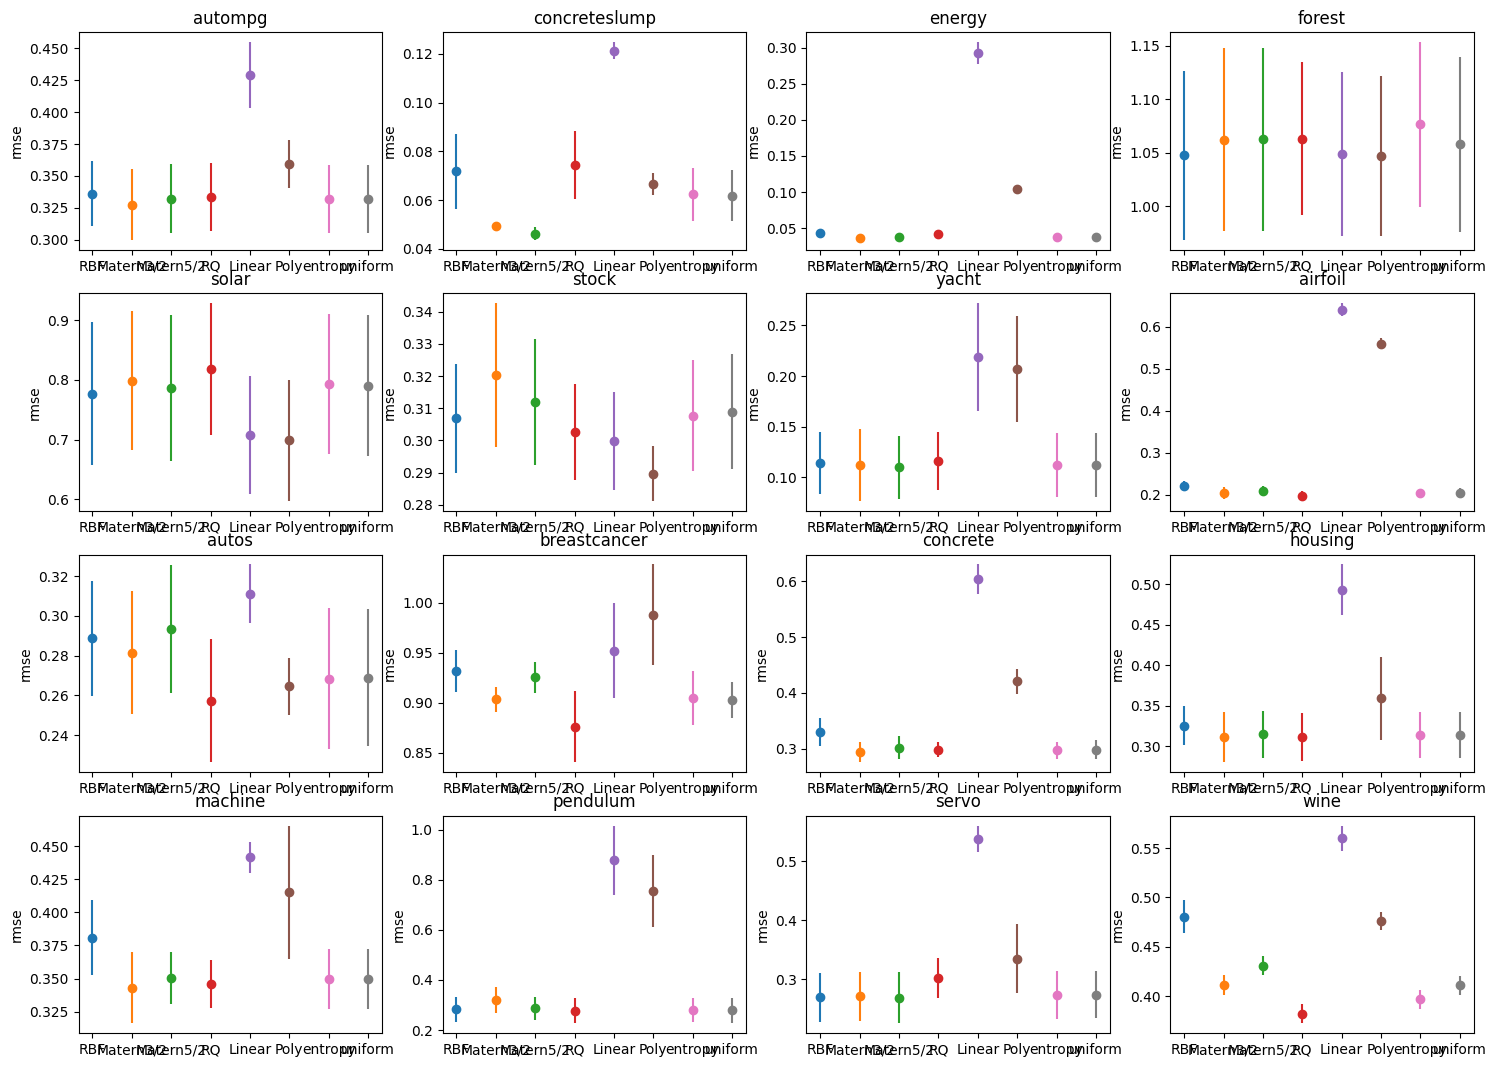

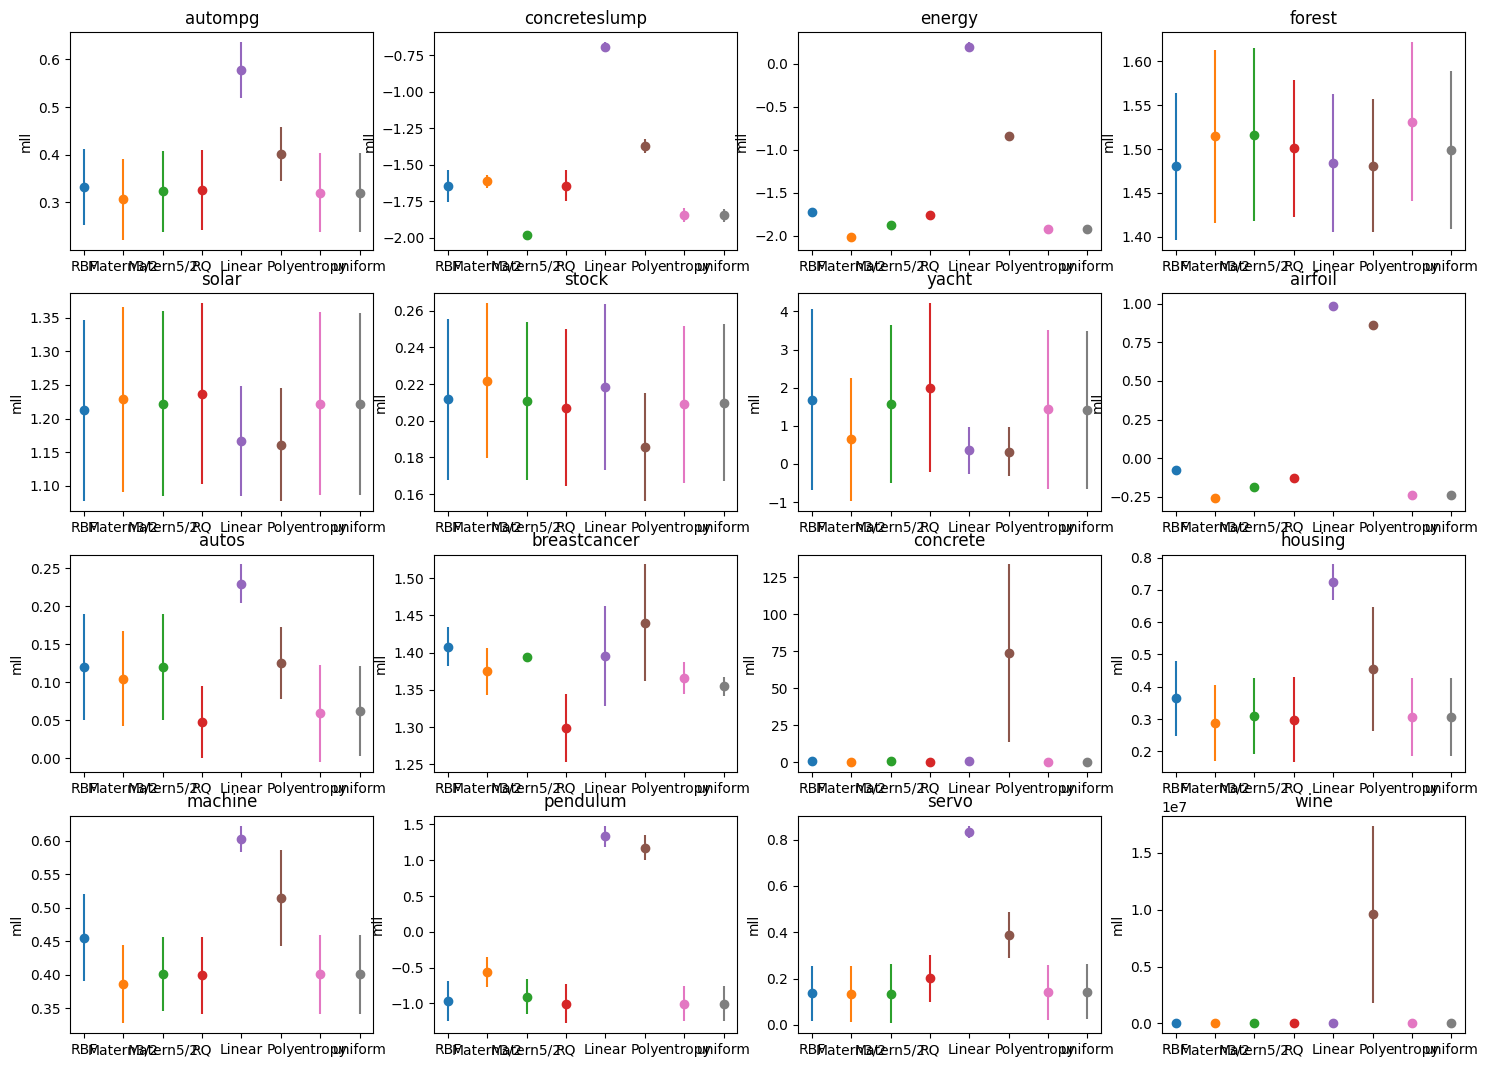

In [127]:
error_measure = "rmse"
plt.figure(figsize=(18,13))
for j,dataset_name in enumerate(datasets):
    plt.subplot(4,4,j+1)
    for i, kernel_name in enumerate(kernel_names[:6]):
        aqui = np.array(all_results_full[dataset_name][kernel_name][error_measure])
        plt.scatter(i,np.nanmean(aqui))
        # print(np.sum(1-np.isnan(aqui)))
        plt.errorbar(i,np.nanmean(aqui),np.nanstd(aqui)/np.sqrt(np.sum(1-np.isnan(aqui))))
    
    aqui2 = all_results_fusion[dataset_name]["gPoE_entropy_normalize_True"][error_measure]
    plt.scatter(i+1,np.mean(aqui2))
    plt.errorbar(i+1,np.mean(aqui2),np.std(aqui2)/np.sqrt(3))
    aqui2 = all_results_fusion[dataset_name]["gPoE_uniform_normalize_True"][error_measure]
    plt.scatter(i+2,np.mean(aqui2))
    plt.errorbar(i+2,np.mean(aqui2),np.std(aqui2)/np.sqrt(3))
    
    ola = kernel_names[:6]
    ola.extend(["entropy","uniform"])
    plt.xticks(range(6+2),ola)  
    # plt.ylim((0,1)) 
    plt.ylabel(error_measure) 
    plt.title(dataset_name)


error_measure = "mll"
plt.figure(figsize=(18,13))
for j,dataset_name in enumerate(datasets):
    plt.subplot(4,4,j+1)
    for i, kernel_name in enumerate(kernel_names[:6]):
        aqui = np.array(all_results_full[dataset_name][kernel_name][error_measure])
        plt.scatter(i,np.nanmean(aqui))
        # print(np.sum(1-np.isnan(aqui)))
        plt.errorbar(i,np.nanmean(aqui),np.nanstd(aqui)/np.sqrt(np.sum(1-np.isnan(aqui))))
    
    aqui2 = all_results_fusion[dataset_name]["gPoE_entropy_normalize_True"][error_measure]
    plt.scatter(i+1,np.mean(aqui2))
    plt.errorbar(i+1,np.mean(aqui2),np.std(aqui2)/np.sqrt(3))
    aqui2 = all_results_fusion[dataset_name]["gPoE_uniform_normalize_True"][error_measure]
    plt.scatter(i+2,np.mean(aqui2))
    plt.errorbar(i+2,np.mean(aqui2),np.std(aqui2)/np.sqrt(3))
    
    ola = kernel_names[:6]
    ola.extend(["entropy","uniform"])
    plt.xticks(range(6+2),ola)  
    # plt.ylim((0,1)) 
    plt.ylabel(error_measure) 
    plt.title(dataset_name)    

In [111]:
all_results_fusion

{'autompg': {'gPoE_uniform_normalize_True': {'rmse': [0.27100350854170036,
    0.3832421891128916,
    0.34106474292699585],
   'mll': [0.14720200058180138, 0.5003609937061058, 0.31346087727048794]},
  'gPoE_entropy_normalize_True': {'rmse': [0.27091647712805655,
    0.383224491674389,
    0.34112000738266884],
   'mll': [0.14699762593715793, 0.5003589112173384, 0.3135900967306623]},
  'gPoE_entropy_normalize_False': {'rmse': [0.2709164771280566,
    0.38322449167438893,
    0.3411200073826688],
   'mll': [0.7111496597762615, 2.8625001235448417, 1.6168204096048158]}},
 'concreteslump': {'gPoE_uniform_normalize_True': {'rmse': [0.08568059838449922,
    0.058687151697993656,
    0.04100173834670992],
   'mll': [-1.805937500257369, -1.7818966063800483, -1.9499632464090466]},
  'gPoE_entropy_normalize_True': {'rmse': [0.08654516797672109,
    0.05931637976863357,
    0.041102398609907116],
   'mll': [-1.8030526083054645, -1.7708822584178918, -1.9582648035465589]},
  'gPoE_entropy_normalize

In [121]:
ola